In [1]:
import nibabel as nib
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import config
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data

## Trainig data

In [2]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')

In [3]:
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [4]:
scan_dimension = scan_100206.shape
x = scan_dimension[0]
y = scan_dimension[1]
z = scan_dimension[2]
b = scan_dimension[3]

In [78]:
scan_100206.shape

(145, 174, 145, 288)

In [5]:
scan_100206_long = np.reshape(scan_100206, (x*y*z, b))

mask_100206_long = np.reshape(mask_100206, (x*y*z, 1))

In [6]:
# Error voxels
indices_beginning_0_all = np.where(scan_100206_long[:, 0] == 0)[0]

In [7]:
mask_100206_long_pro = np.copy(mask_100206_long)

In [8]:
mask_100206_long_pro[indices_beginning_0_all] = 0

In [9]:
scan_100206_long_no_background = process_data.remove_background(scan_100206_long, mask_100206_long_pro)

In [10]:
bvals_all = np.loadtxt(config.data_folder2 + '/100206/bvals') * 1e-3

In [11]:
big_b_indices = np.where(bvals_all != 0.005)[0]

In [12]:
bvals = bvals_all[big_b_indices]
print(bvals.shape)

(270,)


In [13]:
scan_100206_long_no_bg = scan_100206_long_no_background[:, big_b_indices]

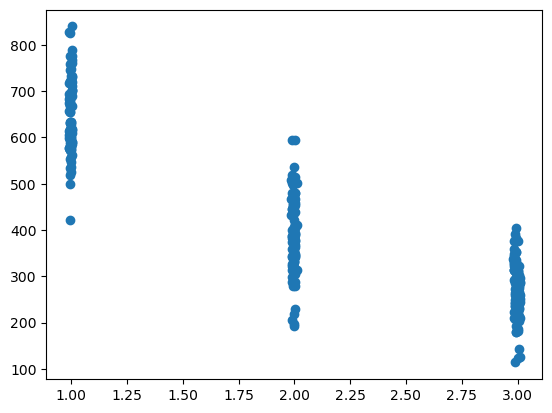

In [19]:
plt.plot(bvals, scan_100206_long_no_bg[1565,:], "o")

In [41]:
np.save('scan_100206_no_b5.npy', scan_100206_long_no_bg)

## Neural Network

In [20]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [21]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [33]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 6))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        s0 = params[:, 5].unsqueeze(1)
        X = s0*(volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso))
        return X, mu_cart, lambda_par, lambda_iso, volume_0, volume_1, s0

In [34]:
n_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')
n = n_all[:,big_b_indices].T
print(n.shape)

b_values = torch.FloatTensor(bvals)
print(b_values.shape)
gradient_directions = torch.FloatTensor(n)

net = BallStickNet(gradient_directions, b_values)

(270, 3)
torch.Size([270])


In [35]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

In [36]:
batch_size = 128
num_batches = len(scan_100206_long_no_bg) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(scan_100206_long_no_bg.astype(np.float32)),
                               batch_size = batch_size, 
                               shuffle = True,
                               num_workers = 2,
                               drop_last = True)

In [ ]:
loss_arr=[]
avg_loss_arr=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 100

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, mu_cart_pred, lambda_par_pred, lambda_iso_pred,  volume_0_pred, volume_1_pred, s0_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
            print("s0_pred:")
            print(s0_pred.shape)
            print(s0_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_arr.append(running_loss)
    avg_loss_arr.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1
print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 162.32it/s]


Loss: 5075172112.25
Average Loss: 694467.9956554461
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.46it/s]


Loss: 5095713264.5
Average Loss: 697278.7718253968
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.50it/s]


Loss: 5068059032.5625
Average Loss: 693494.6678383278
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 141.16it/s]


Loss: 5068976420.0
Average Loss: 693620.1997810618
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 149.08it/s]


Loss: 5064757128.8125
Average Loss: 693042.8474018199
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.45it/s]


Loss: 5071590624.5625
Average Loss: 693977.9179751643
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 127.32it/s]


Loss: 5085208667.4375
Average Loss: 695841.361170977
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 126.00it/s]


Loss: 5143885262.375
Average Loss: 703870.4518849206
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 121.44it/s]


Loss: 4568631752.46875
Average Loss: 625154.8648698344
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:03<00:00, 115.47it/s]


Loss: 2638973086.40625
Average Loss: 361107.42835334566
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


  2%|▉                                                         | 121/7308 [00:03<01:08, 104.45it/s]

X_batch: 
torch.Size([128, 270])
tensor([[2115.3005,  757.2137,  700.0132,  ..., 2172.7114, 1114.4070,
          650.8449],
        [1956.1687, 1155.9437,  394.3768,  ..., 1815.7401, 1631.2898,
          971.2665],
        [ 881.3658,  337.0159,  409.0845,  ...,  858.7752,  468.1859,
          338.6093],
        ...,
        [2683.3438, 1795.0408,  715.4279,  ..., 2618.0872, 1072.4104,
          896.2180],
        [1321.9349, 1131.0836,  741.0302,  ..., 1700.2349,  465.9778,
          990.7380],
        [2108.7556, 1097.3899,  443.8245,  ...,  807.0163, 1115.6411,
          541.9219]])
X_pred: 
torch.Size([128, 270])
tensor([[1428.2400, 1314.3591,  803.1038,  ..., 1227.3922, 1433.4159,
         1022.8168],
        [1575.9589, 1437.1046, 1384.4594,  ..., 1516.4391, 1584.3718,
         1269.0536],
        [ 631.8799,  562.1760,  571.1750,  ...,  590.5508,  611.6880,
          485.9250],
        ...,
        [1938.5613, 1981.7584, 1647.2203,  ..., 1959.3418, 1903.3505,
         1897.5109]

100%|█████████████████████████████████████████████████████████| 7308/7308 [01:08<00:00, 107.09it/s]


Loss: 1792050792.5625
Average Loss: 245217.67823788998
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:10<00:00, 103.45it/s]


Loss: 1792326534.84375
Average Loss: 245255.4098034688
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:07<00:00, 108.53it/s]


Loss: 1671322441.953125
Average Loss: 228697.65215560002
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:08<00:00, 106.52it/s]


Loss: 1583575738.8125
Average Loss: 216690.7141232211
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:10<00:00, 104.02it/s]


Loss: 1362141712.796875
Average Loss: 186390.49162518815
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:08<00:00, 106.80it/s]


Loss: 1315364026.4375
Average Loss: 179989.60405548714
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:10<00:00, 104.14it/s]


Loss: 1298701015.25
Average Loss: 177709.49852900932
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:08<00:00, 106.03it/s]


Loss: 1288787976.5234375
Average Loss: 176353.0345543839
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:07<00:00, 108.69it/s]


Loss: 1274631721.359375
Average Loss: 174415.94435678367
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:08<00:00, 107.42it/s]


Loss: 1266252847.375
Average Loss: 173269.40987616312
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:07<00:00, 107.91it/s]


Loss: 1260360705.734375
Average Loss: 172463.15075730364
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:06<00:00, 109.72it/s]


Loss: 1255079061.828125
Average Loss: 171740.42991627325
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:09<00:00, 105.24it/s]


Loss: 1250979395.609375
Average Loss: 171179.44658037424
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:09<00:00, 105.34it/s]


Loss: 1246795593.3828125
Average Loss: 170606.9503807899
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:06<00:00, 110.42it/s]


Loss: 1245116346.4140625
Average Loss: 170377.16836536158
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:06<00:00, 109.63it/s]


Loss: 1243478535.375
Average Loss: 170153.0562910509
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:06<00:00, 110.53it/s]


Loss: 1240960115.4609375
Average Loss: 169808.44491802648
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:06<00:00, 110.47it/s]


Loss: 1237353526.1328125
Average Loss: 169314.93242101977
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 112.39it/s]


Loss: 1239278995.265625
Average Loss: 169578.40657712438
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 113.02it/s]


Loss: 1238100244.234375
Average Loss: 169417.11059583674
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 112.78it/s]


Loss: 1233964085.734375
Average Loss: 168851.13378959702
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:07<00:00, 108.84it/s]


Loss: 1233667753.0
Average Loss: 168810.58470169676
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 110.86it/s]


Loss: 1231416330.3828125
Average Loss: 168502.5082625633
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:03<00:00, 115.19it/s]


Loss: 1230768894.21875
Average Loss: 168413.91546507252
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 117.22it/s]


Loss: 1231352706.296875
Average Loss: 168493.80217527025
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 117.80it/s]


Loss: 1232222881.9375
Average Loss: 168612.8738283388
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 118.80it/s]


Loss: 1230310531.859375
Average Loss: 168351.19483571086
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 118.72it/s]


Loss: 1230720893.09375
Average Loss: 168407.34716663245
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 120.81it/s]


Loss: 1229542520.140625
Average Loss: 168246.10292017309
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 122.94it/s]


Loss: 1229361926.125
Average Loss: 168221.39109537494
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 122.97it/s]


Loss: 1229582296.046875
Average Loss: 168251.545709753
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 120.72it/s]


Loss: 1229616733.0078125
Average Loss: 168256.25793757697
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 117.65it/s]


Loss: 1228732751.15625
Average Loss: 168135.29709308292
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 117.19it/s]


Loss: 1229830263.1171875
Average Loss: 168285.47661702073
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 122.19it/s]


Loss: 1228768574.8828125
Average Loss: 168140.1990808446
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 123.18it/s]


Loss: 1229260599.953125
Average Loss: 168207.5259924911
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 126.95it/s]


Loss: 1226036234.1328125
Average Loss: 167766.31556278223
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 122.73it/s]


Loss: 1226636974.796875
Average Loss: 167848.5187187842
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 126.84it/s]


Loss: 1227887208.578125
Average Loss: 168019.59613822182
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 124.61it/s]


Loss: 1227901529.2734375
Average Loss: 168021.55572980808
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 128.07it/s]


Loss: 1228676370.7421875
Average Loss: 168127.58220336447
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 128.54it/s]


Loss: 1226689838.078125
Average Loss: 167855.7523369082
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 122.99it/s]


Loss: 1229964401.90625
Average Loss: 168303.8316784688
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 6


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 127.25it/s]


Loss: 1227837723.0859375
Average Loss: 168012.82472440306
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 7


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 127.58it/s]


Loss: 1226950645.6171875
Average Loss: 167891.44028697148
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 8


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 124.32it/s]


Loss: 1224674453.8125
Average Loss: 167579.97452278325
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 131.79it/s]


Loss: 1226727223.6796875
Average Loss: 167860.86804593424
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 1


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 128.83it/s]


Loss: 1224858583.6875
Average Loss: 167605.17018165023
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 2


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 130.23it/s]


Loss: 1230520570.109375
Average Loss: 168379.9357018849
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 3


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 126.73it/s]


Loss: 1235071860.9765625
Average Loss: 169002.71770341578
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 4


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 132.97it/s]


Loss: 1235005828.9921875
Average Loss: 168993.68212810447
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 5


100%|█████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.58it/s]


Loss: 1233997186.1796875
Average Loss: 168855.66313350952
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 6


 53%|█████████████████████████████▉                           | 3838/7308 [00:30<00:25, 134.94it/s]

In [41]:
net.load_state_dict(final_model)

<All keys matched successfully>

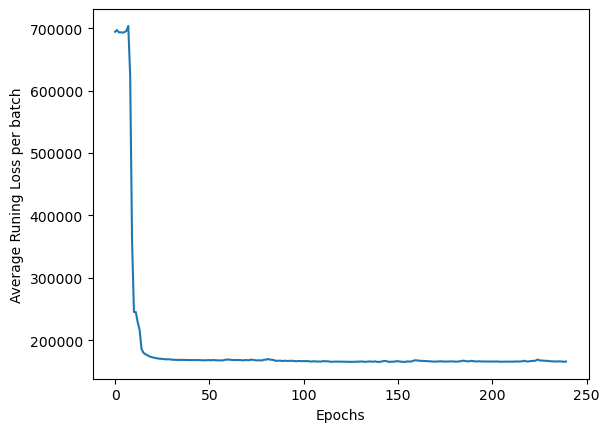

In [40]:
epoch_arr = np.arange(0, len(avg_loss_arr))
loss_arr = np.array(avg_loss_arr)
plt.plot(avg_loss_arr)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [55]:
len(loss_arr)

240

In [42]:
net.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=270, out_features=270, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=270, out_features=270, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=270, out_features=270, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=270, out_features=270, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=270, out_features=270, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=270, out_features=270, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=270, out_features=6, bias=True)
  )
)

In [44]:
torch.save(final_model, 'model_100206_240e.pt')

In [45]:
X_pred_train, mu_cart_pred_train, lambda_par_pred_train, lambda_iso_pred_train,  volume_0_pred_train, volume_1_pred_train, s0_pred_train = net(torch.from_numpy(scan_100206_long_no_bg.astype(np.float32)))

In [46]:
X_pred_train.shape

torch.Size([935442, 270])

In [60]:
# Load model

# net_test = BallStickNet(gradient_directions, b_values)
# net_test.load_state_dict(torch.load('model_100206_61e.pt'))
# net_test.eval()
# X_pred_test, mu_cart_pred_test, lambda_par_pred_test, lambda_iso_pred_test,  volume_0_pred_test, volume_1_pred_test, s0_pred_test = net_test(torch.from_numpy(normalized_scan_100206.astype(np.float32)))

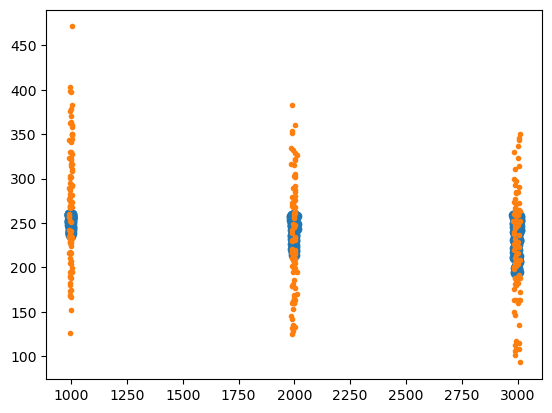

In [50]:
plt.plot(bvals*1e03, X_pred_train[178,:].detach().numpy(),  "o")
# plt.plot(X_pred_train[110,:].detach().numpy())
plt.plot(bvals*1e03,scan_100206_long_no_bg[178,:], ".")

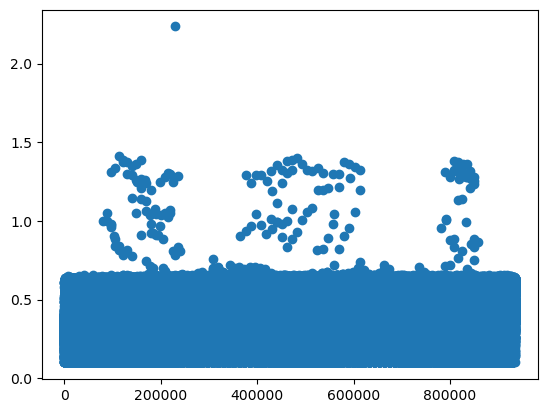

In [54]:
plt.plot(lambda_iso_pred_train.detach().numpy(), 'o')

In [52]:
torch.min(lambda_par_pred_train)

tensor(0.1000, grad_fn=<MinBackward1>)

In [53]:
torch.max(lambda_par_pred_train)

tensor(3., grad_fn=<MaxBackward1>)

## Parameter maps

In [70]:
def add_bg(mask_long, params):
    resume_params = np.copy(mask_long)
    no_bg_indices = np.where(mask_long == 1)[0]
    for i, index in enumerate(no_bg_indices):
        resume_params[index] = params[i]
    return resume_params

In [73]:
lambda_par_pred_train_with_bg = add_bg(mask_100206_long_pro, lambda_par_pred_train.detach().numpy())

In [82]:
lambda_par_pred_train_3d = np.reshape(lambda_par_pred_train_with_bg, (145, 174, 145))

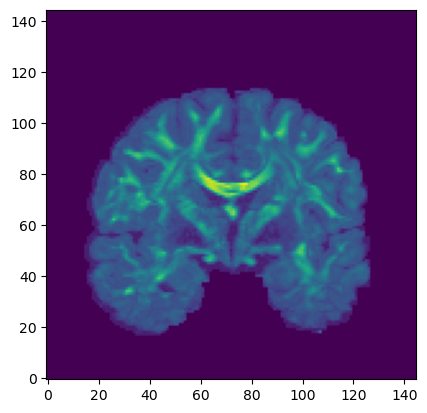

In [110]:
plt.imshow(lambda_par_pred_train_3d[:,100,:].squeeze().T, origin='lower')

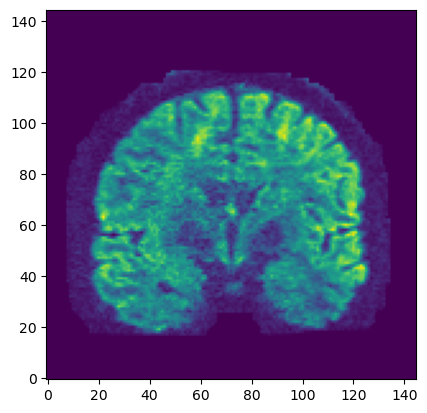

In [113]:
plt.imshow(scan_100206[:,100,:,1].T, origin='lower')

In [ ]:
X_pred_train_with_bg = add_bg(mask_100206_long_pro, X_pred_train.detach().numpy())

In [ ]:
X_pred_train_3d = np.reshape(X_pred_train_with_bg, (145, 174, 145, 288))

In [114]:
X_pred_train.shape

torch.Size([935442, 270])

In [90]:
lambda_iso_pred_train_with_bg = add_bg(mask_100206_long_pro, lambda_iso_pred_train.detach().numpy())

In [91]:
lambda_iso_pred_train_3d = np.reshape(lambda_iso_pred_train_with_bg, (145, 174, 145))

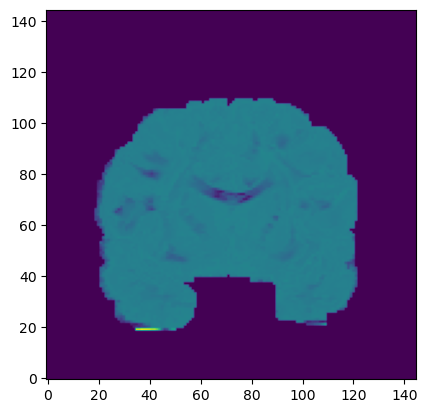

In [93]:
plt.imshow(lambda_iso_pred_train_3d[:,110,:].squeeze().T, origin='lower')

In [95]:
volume_0_pred_train_with_bg = add_bg(mask_100206_long_pro, volume_0_pred_train.detach().numpy())

In [96]:
volume_0_pred_train_3d = np.reshape(volume_0_pred_train_with_bg, (145, 174, 145))

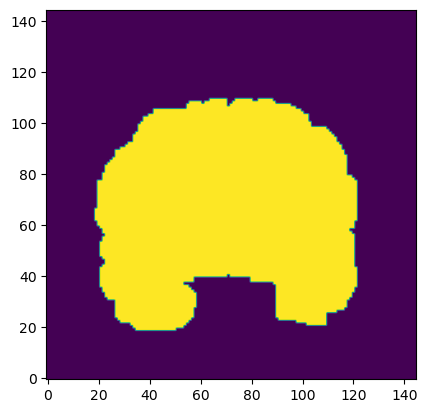

In [97]:
plt.imshow(volume_0_pred_train_3d[:,110,:].squeeze().T, origin='lower')

In [98]:
volume_1_pred_train_with_bg = add_bg(mask_100206_long_pro, volume_1_pred_train.detach().numpy())

In [99]:
volume_1_pred_train_3d = np.reshape(volume_1_pred_train_with_bg, (145, 174, 145))

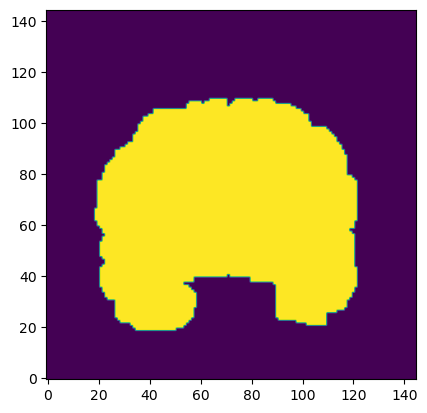

In [100]:
plt.imshow(volume_1_pred_train_3d[:,110,:].squeeze().T, origin='lower')